# Gastric-Brain Coupling with Real fMRI Data

This tutorial demonstrates the complete gastric-brain phase coupling
pipeline using real fMRIPrep-preprocessed BOLD data and concurrent EGG.

**What you'll learn:**
- Loading and aligning fMRI-concurrent EGG with BOLD data
- EGG channel selection and narrowband filtering
- Spatial smoothing of BOLD data
- BOLD confound regression and phase extraction
- Artifact detection and volume censoring
- Computing voxelwise PLV maps
- Surrogate statistical testing
- Visualizing volumetric coupling maps with nilearn

**Prerequisites:** ``pip install gastropy[neuro]`` (adds nibabel, nilearn, pooch)

**Data:** ~1.2 GB download on first run (cached for subsequent runs).
Session 0008 from the semi_precision study: 8-channel EGG at 10 Hz,
fMRIPrep BOLD in MNI152NLin2009cAsym space (2 mm), TR = 1.856 s.

**Expected runtime:** ~10 minutes (mostly surrogate computation).

In [1]:
import time

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.image import smooth_img

import gastropy as gp
from gastropy.neuro.fmri import (
    align_bold_to_egg,
    apply_volume_cuts,
    artifact_mask_to_volumes,
    bold_voxelwise_phases,
    compute_plv_map,
    compute_surrogate_plv_map,
    create_volume_windows,
    phase_per_volume,
    regress_confounds,
    to_nifti,
)
from gastropy.signal import detect_phase_artifacts, resample_signal

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## 1. Load Data

GastroPy provides ``fetch_fmri_bold`` to download preprocessed BOLD,
brain mask, and confounds from a GitHub Release. The EGG data is
bundled with the package.

In [2]:
# Download BOLD data (~1.2 GB, cached after first run)
fmri_paths = gp.fetch_fmri_bold(session="0008")

# Load bundled EGG data
egg = gp.load_fmri_egg(session="0008")

print("EGG data:")
print(f"  Signal shape: {egg['signal'].shape} (channels x samples)")
print(f"  Sampling rate: {egg['sfreq']} Hz")
print(f"  Scanner triggers: {len(egg['trigger_times'])}")
print(f"  TR: {egg['tr']} s")
print(f"  Duration: {egg['duration_s']:.0f} s ({egg['duration_s'] / 60:.1f} min)")

C:\Users\Micah\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EGG data:
  Signal shape: (8, 7795) (channels x samples)
  Sampling rate: 10.0 Hz
  Scanner triggers: 420
  TR: 1.856 s
  Duration: 780 s (13.0 min)


### 1b. Load and Smooth BOLD

We load the BOLD NIfTI directly with nibabel, apply 6 mm FWHM Gaussian
spatial smoothing with nilearn, then mask to extract brain voxels.
Smoothing before masking is standard practice.

In [3]:
t0 = time.time()

# Load NIfTI images
bold_img = nib.load(fmri_paths["bold"])
mask_img = nib.load(fmri_paths["mask"])

# Spatial smoothing (6 mm FWHM Gaussian)
bold_smooth = smooth_img(bold_img, fwhm=6)

# Extract brain voxels using the mask
mask_data = mask_img.get_fdata().astype(bool)
bold_4d = bold_smooth.get_fdata(dtype=np.float32)
vol_shape = mask_data.shape
n_volumes = bold_4d.shape[-1]
bold_2d_all = bold_4d[mask_data]  # (n_voxels, n_volumes)
affine = bold_img.affine

elapsed = time.time() - t0
print(f"BOLD loaded + smoothed (6 mm) in {elapsed:.1f} s")
print(f"  Volume shape: {vol_shape}")
print(f"  Volumes: {n_volumes}")
print(f"  Brain voxels: {bold_2d_all.shape[0]:,}")
print(f"  Memory: {bold_2d_all.nbytes / 1e9:.2f} GB")

# Load confounds
confounds = pd.read_csv(fmri_paths["confounds"], sep="\t")
print(f"\nConfounds: {confounds.shape[0]} rows x {confounds.shape[1]} columns")

BOLD loaded + smoothed (6 mm) in 11.8 s
  Volume shape: (85, 106, 90)
  Volumes: 420
  Brain voxels: 358,147
  Memory: 0.60 GB

Confounds: 420 rows x 589 columns


## 2. Align BOLD Volumes to EGG Triggers

The BOLD file from fMRIPrep may contain more volumes than EGG triggers
(e.g., dummy scans at the start/end). We align by keeping only the
BOLD volumes that correspond to EGG scanner triggers.

In [4]:
n_triggers = len(egg["trigger_times"])
print(f"BOLD volumes: {n_volumes}")
print(f"EGG triggers: {n_triggers}")
print(f"Discarding {n_volumes - n_triggers} extra BOLD volumes")

bold_2d, confounds_aligned = align_bold_to_egg(bold_2d_all, n_triggers, confounds)
print(f"\nAligned BOLD: {bold_2d.shape}")
print(f"Aligned confounds: {confounds_aligned.shape}")

BOLD volumes: 420
EGG triggers: 420
Discarding 0 extra BOLD volumes

Aligned BOLD: (358147, 420)
Aligned confounds: (420, 589)


## 3. EGG Processing: Channel Selection and Filtering

We identify the best EGG channel (strongest gastric rhythm) and its
individual peak frequency, then narrowband filter the EGG at that
frequency.

In [5]:
sfreq = egg["sfreq"]
ch_names = list(egg["ch_names"])

# Select best channel and peak frequency
best_idx, peak_freq, freqs, psd = gp.select_best_channel(egg["signal"], sfreq)
print(f"Best channel: {ch_names[best_idx]} (index {best_idx})")
print(f"Peak frequency: {peak_freq:.4f} Hz ({peak_freq * 60:.2f} cpm)")

# Compute all-channel PSD for plotting
all_psd = np.column_stack([gp.psd_welch(egg["signal"][i], sfreq)[1] for i in range(egg["signal"].shape[0])]).T

Best channel: EGG3 (index 2)
Peak frequency: 0.0490 Hz (2.94 cpm)


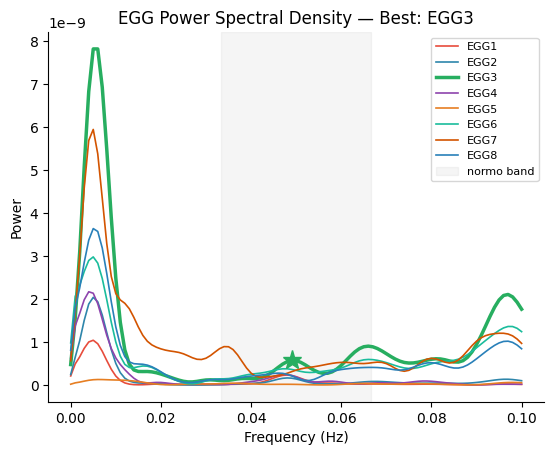

In [6]:
fig, ax = gp.plot_psd(freqs, all_psd, best_idx=best_idx, peak_freq=peak_freq, ch_names=ch_names)
ax.set_title(f"EGG Power Spectral Density \u2014 Best: {ch_names[best_idx]}")
plt.show()

In [7]:
# Narrowband filter at individual peak frequency
hwhm = 0.015  # Hz (half-width at half-maximum)
low_hz = peak_freq - hwhm
high_hz = peak_freq + hwhm
print(f"Filter band: {low_hz:.4f} - {high_hz:.4f} Hz")

filtered, filt_info = gp.apply_bandpass(egg["signal"][best_idx], sfreq, low_hz=low_hz, high_hz=high_hz)
print(f"Filter taps: {filt_info.get('fir_numtaps', 'N/A')}")

# Phase at 10 Hz (for artifact detection later)
phase_10hz, _ = gp.instantaneous_phase(filtered)

# Resample to fMRI rate, then Hilbert for per-volume phase
fmri_sfreq = 1.0 / egg["tr"]
filtered_fmri, actual_fmri_sfreq = resample_signal(filtered, sfreq, fmri_sfreq)
phase_fmri, analytic_fmri = gp.instantaneous_phase(filtered_fmri)
print(f"Resampled to fMRI rate: {len(filtered_fmri)} samples @ {actual_fmri_sfreq:.4f} Hz")

Filter band: 0.0340 - 0.0640 Hz


Filter taps: 501
Resampled to fMRI rate: 420 samples @ 0.5388 Hz


## 4. Per-Volume EGG Phase

Map the fMRI-rate EGG phase to one phase value per volume using the
scanner trigger windows, then trim 21 transient volumes from each edge
(standard practice to remove filter ringing artifacts).

In [8]:
windows = create_volume_windows(egg["trigger_times"], egg["tr"], n_triggers)
egg_vol_phase = phase_per_volume(analytic_fmri, windows)

begin_cut, end_cut = 21, 21
egg_phase = apply_volume_cuts(egg_vol_phase, begin_cut, end_cut)

print(f"Per-volume phases: {len(egg_vol_phase)}")
print(f"After trimming ({begin_cut} + {end_cut}): {len(egg_phase)}")

Per-volume phases: 420
After trimming (21 + 21): 378


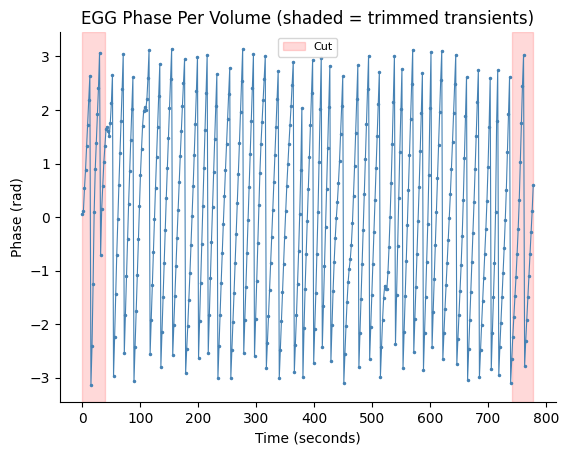

In [9]:
fig, ax = gp.plot_volume_phase(egg_vol_phase, tr=egg["tr"], cut_start=begin_cut, cut_end=end_cut)
ax.set_title("EGG Phase Per Volume (shaded = trimmed transients)")
plt.show()

## 5. Artifact Detection and Volume Censoring

Detect phase artifacts in the continuous 10 Hz EGG phase and map them
to volume-level. Volumes containing any artifact sample are censored
(excluded from PLV computation).

In [10]:
# Detect phase artifacts on continuous 10 Hz signal
times_10hz = np.arange(len(phase_10hz)) / sfreq
artifact_info = detect_phase_artifacts(phase_10hz, times_10hz)

print(f"Artifacts detected: {artifact_info['n_artifacts']}")
print(f"Artifact samples: {artifact_info['artifact_mask'].sum()} / {len(phase_10hz)}")

# Map sample-level artifacts to volume-level mask
vol_mask = artifact_mask_to_volumes(
    artifact_info["artifact_mask"],
    egg["trigger_times"],
    sfreq,
    egg["tr"],
    begin_cut=begin_cut,
    end_cut=end_cut,
)

print(f"\nVolume mask: {len(vol_mask)} volumes")
print(f"  Clean: {vol_mask.sum()}")
print(f"  Censored: {(~vol_mask).sum()}")

Artifacts detected: 5
Artifact samples: 1077 / 7795

Volume mask: 378 volumes
  Clean: 339
  Censored: 39


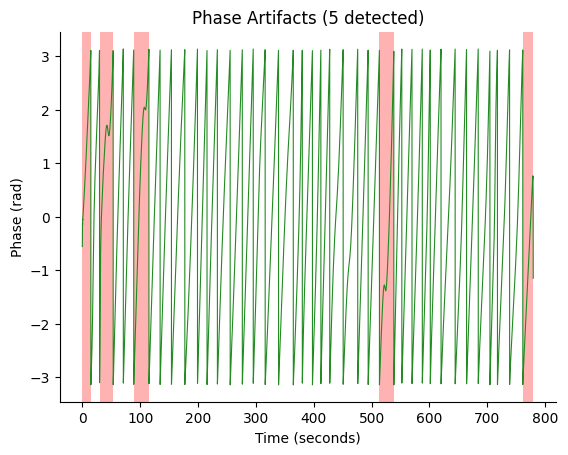

In [11]:
fig, ax = gp.plot_artifacts(phase_10hz, times_10hz, artifact_info)
ax.set_title(f"Phase Artifacts ({artifact_info['n_artifacts']} detected)")
plt.show()

## 6. BOLD Processing

### 6a. Confound Regression

Remove motion and noise confounds from BOLD data using GLM regression.
Default regressors: 6 motion parameters + 6 aCompCor components
(12 total).

In [12]:
t0 = time.time()
residuals = regress_confounds(bold_2d, confounds_aligned)
elapsed = time.time() - t0
print(f"Confound regression: {elapsed:.1f} s ({residuals.shape[0]:,} voxels)")

Confound regression: 5.0 s (358,147 voxels)


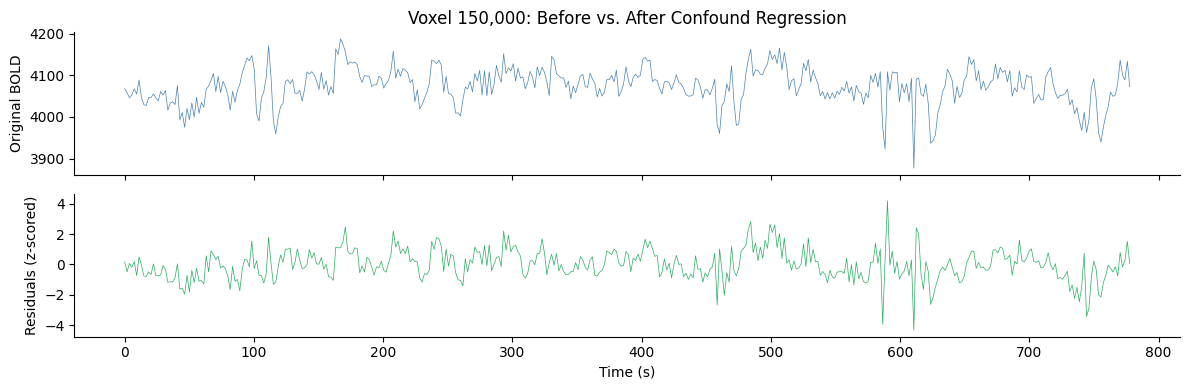

In [13]:
# Show effect of confound regression on an example voxel
voxel_idx = 150000
fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

t_vol = np.arange(n_triggers) * egg["tr"]
axes[0].plot(t_vol, bold_2d[voxel_idx], linewidth=0.5, color="steelblue")
axes[0].set_ylabel("Original BOLD")
axes[0].set_title(f"Voxel {voxel_idx:,}: Before vs. After Confound Regression")

axes[1].plot(t_vol, residuals[voxel_idx], linewidth=0.5, color="#27AE60")
axes[1].set_ylabel("Residuals (z-scored)")
axes[1].set_xlabel("Time (s)")

for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

### 6b. BOLD Phase Extraction

Bandpass filter each voxel at the same gastric frequency as the EGG,
then extract instantaneous phase via Hilbert transform.

We use an IIR (Butterworth) filter because BOLD time series are too
short (~420 volumes) for the FIR filter that works at EGG sampling
rates. The vectorized IIR path processes all ~350K voxels at once.

In [14]:
t0 = time.time()
bold_phases = bold_voxelwise_phases(
    residuals,
    peak_freq,
    sfreq=1 / egg["tr"],
    begin_cut=begin_cut,
    end_cut=end_cut,
)
elapsed = time.time() - t0
print(f"BOLD phase extraction: {elapsed:.1f} s ({residuals.shape[0]:,} voxels)")
print(f"BOLD phases shape: {bold_phases.shape}")
print(f"EGG phase length:  {len(egg_phase)} (should match)")

BOLD phase extraction: 6.8 s (358,147 voxels)
BOLD phases shape: (358147, 378)
EGG phase length:  378 (should match)


## 7. Compute PLV Map

Phase-locking value (PLV) between EGG phase and each BOLD voxel's
phase. Values range from 0 (no coupling) to 1 (perfect phase locking).

We pass the artifact mask to exclude censored volumes from the PLV
computation.

In [15]:
plv_3d = compute_plv_map(
    egg_phase,
    bold_phases,
    vol_shape=vol_shape,
    mask_indices=mask_data,
    artifact_mask=vol_mask,
)

plv_flat = plv_3d[mask_data]

print(f"PLV volume shape: {plv_3d.shape}")
print(f"Volumes used: {vol_mask.sum()} / {len(vol_mask)} (after censoring)")
print("PLV statistics (brain voxels only):")
print(f"  Mean:   {plv_flat.mean():.4f}")
print(f"  Median: {np.median(plv_flat):.4f}")
print(f"  Max:    {plv_flat.max():.4f}")
print(f"  Std:    {plv_flat.std():.4f}")

PLV volume shape: (85, 106, 90)
Volumes used: 339 / 378 (after censoring)
PLV statistics (brain voxels only):
  Mean:   0.1922
  Median: 0.1802
  Max:    0.6660
  Std:    0.1006


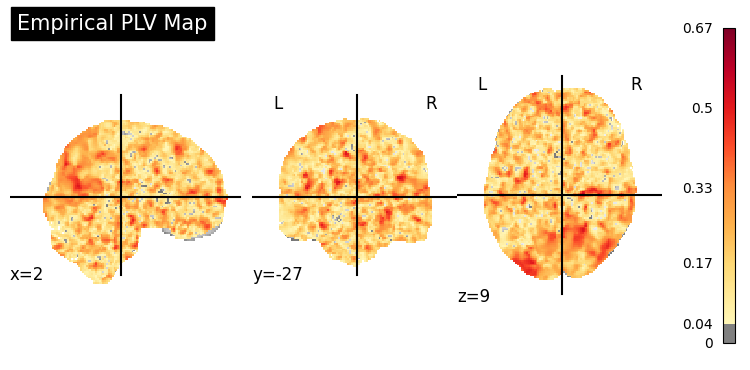

In [16]:
plv_img = to_nifti(plv_3d, affine)

# Stat map overlay on MNI template
display = gp.plot_coupling_map(plv_img, threshold=0.04, title="Empirical PLV Map")
plt.show()

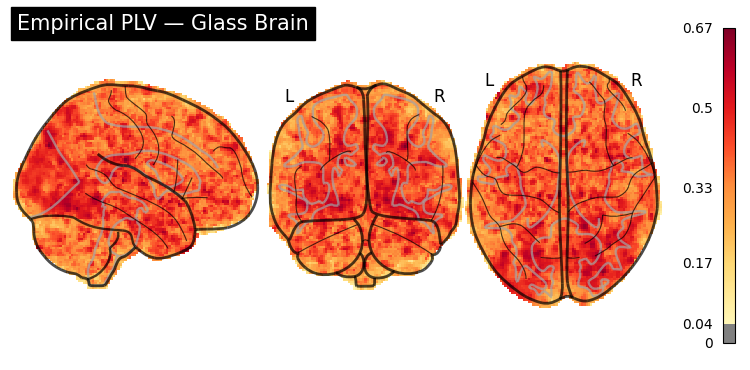

In [17]:
# Glass brain (transparent overview)
display = gp.plot_glass_brain(plv_img, threshold=0.04, title="Empirical PLV \u2014 Glass Brain")
plt.show()

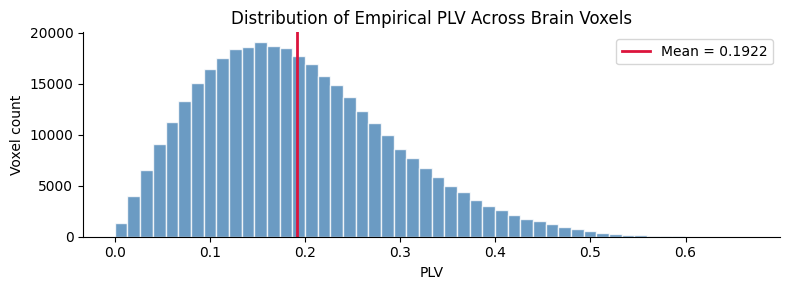

In [18]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(plv_flat, bins=50, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(plv_flat.mean(), color="crimson", linewidth=2, label=f"Mean = {plv_flat.mean():.4f}")
ax.set_xlabel("PLV")
ax.set_ylabel("Voxel count")
ax.set_title("Distribution of Empirical PLV Across Brain Voxels")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

## 8. Surrogate Statistical Testing

Observed PLV may be non-zero by chance due to autocorrelation. We test
significance using the **circular time-shift** method: shift the EGG
phase by random offsets and recompute PLV to build a null distribution.

We use 200 surrogates (publication-quality). The artifact mask is
applied consistently to each surrogate shift.

In [19]:
t0 = time.time()
surr_3d = compute_surrogate_plv_map(
    egg_phase,
    bold_phases,
    vol_shape=vol_shape,
    mask_indices=mask_data,
    n_surrogates=200,
    seed=42,
    artifact_mask=vol_mask,
)
elapsed = time.time() - t0
surr_flat = surr_3d[mask_data]

print(f"Surrogate PLV: {elapsed:.1f} s (200 circular shifts)")
print("Surrogate PLV (brain voxels):")
print(f"  Mean: {surr_flat.mean():.4f}")
print(f"  Max:  {surr_flat.max():.4f}")

Surrogate PLV: 752.0 s (200 circular shifts)
Surrogate PLV (brain voxels):
  Mean: 0.1746
  Max:  0.3456


In [20]:
# Z-score: empirical - surrogate (positive = true coupling)
z_3d = np.zeros_like(plv_3d)
z_3d[mask_data] = gp.coupling_zscore(plv_flat, surr_flat)
z_flat = z_3d[mask_data]

print("Coupling z-score (brain voxels):")
print(f"  Mean:  {z_flat.mean():.4f}")
print(f"  Max:   {z_flat.max():.4f}")
print(f"  >0.01: {(z_flat > 0.01).sum():,} voxels ({(z_flat > 0.01).mean():.1%})")

Coupling z-score (brain voxels):
  Mean:  0.0176
  Max:   0.5419
  >0.01: 171,735 voxels (48.0%)


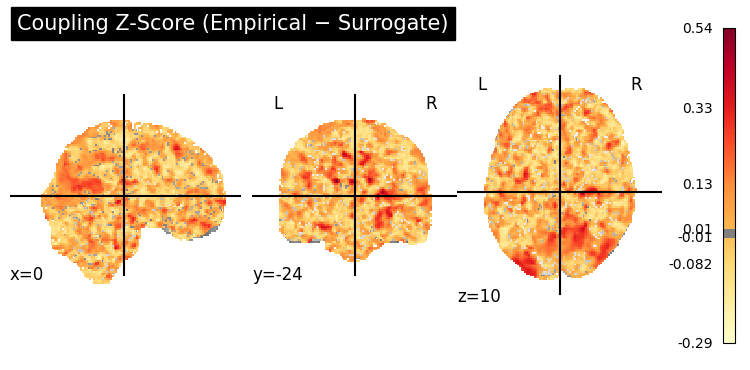

In [21]:
z_img = to_nifti(z_3d, affine)

display = gp.plot_coupling_map(
    z_img,
    threshold=0.01,
    title="Coupling Z-Score (Empirical \u2212 Surrogate)",
    cmap="YlOrRd",
)
plt.show()

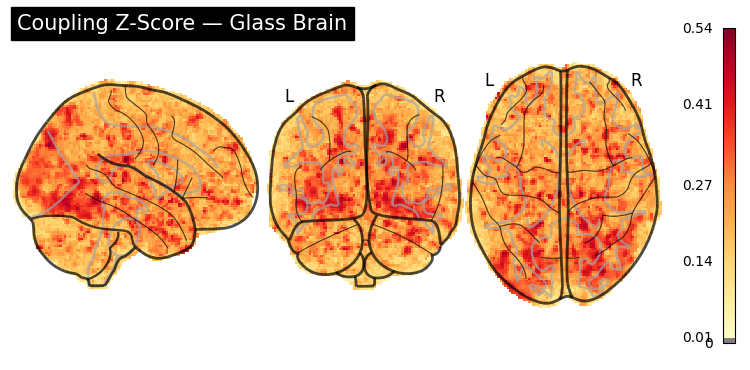

In [22]:
display = gp.plot_glass_brain(
    z_img,
    threshold=0.01,
    title="Coupling Z-Score \u2014 Glass Brain",
)
plt.show()

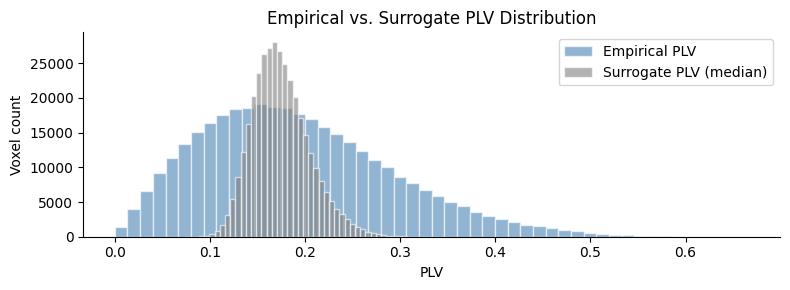

In [23]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(plv_flat, bins=50, alpha=0.6, color="steelblue", edgecolor="white", label="Empirical PLV")
ax.hist(surr_flat, bins=50, alpha=0.6, color="grey", edgecolor="white", label="Surrogate PLV (median)")
ax.set_xlabel("PLV")
ax.set_ylabel("Voxel count")
ax.set_title("Empirical vs. Surrogate PLV Distribution")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

## 9. Summary

This tutorial demonstrated the complete Rebollo et al. gastric-brain
coupling pipeline on real fMRIPrep data:

| Step | Function | Time |
|------|----------|------|
| Load + smooth BOLD | nibabel + ``smooth_img(fwhm=6)`` | ~10 s |
| Align volumes | ``align_bold_to_egg`` | instant |
| EGG channel selection | ``select_best_channel`` | instant |
| EGG bandpass + resample + phase | ``apply_bandpass`` + ``resample_signal`` + ``instantaneous_phase`` | instant |
| Per-volume phase | ``phase_per_volume`` + ``apply_volume_cuts`` | instant |
| Artifact detection | ``detect_phase_artifacts`` + ``artifact_mask_to_volumes`` | instant |
| Confound regression | ``regress_confounds`` | ~5 s |
| BOLD phase extraction | ``bold_voxelwise_phases`` (IIR, vectorized) | ~7 s |
| PLV map (with mask) | ``compute_plv_map`` | ~1 s |
| Surrogate testing (with mask) | ``compute_surrogate_plv_map`` (200 shifts) | ~10 min |
| Visualization | ``plot_coupling_map`` / ``plot_glass_brain`` | instant |

**Key parameters:**
- EGG peak frequency: individual (data-driven)
- Filter bandwidth: peak Â± 0.015 Hz (HWHM)
- Spatial smoothing: 6 mm FWHM Gaussian
- Volume trimming: 21 from each edge
- Artifact censoring: volumes with bad EGG phase excluded
- Confounds: 6 motion + 6 aCompCor (12 regressors)
- BOLD filter: IIR Butterworth order 4 (vectorized)

**For publication-quality results:**
- Consider using the full surrogate distribution (``stat="all"``)
  to compute permutation p-values and FDR correction